In [1]:
#| default_exp inverse_design

In [2]:
#| exporti
import autograd.numpy as npa
import matplotlib.pylab as plt
import numpy as np
from ceviche import jacobian
from ceviche.modes import insert_mode
from inverse_design.brushes import notched_square_brush, show_mask
from inverse_design.conditional_generator import (
    new_latent_design,
    transform,
)
from inverse_design.local_generator import (
    generate_feasible_design,
    generate_feasible_design_mask
)
from inverse_design.direct_optimization import huber_loss
from inverse_design.naive_inverse_design import (
    init_domain,
    mask_combine_epsr,
    mode_overlap,
    viz_sim,
)
from jax.example_libraries.optimizers import adam
from tqdm.notebook import trange

> This notebook was adapted from Ceviche's [inverse design introduction](https://github.com/fancompute/workshop-invdesign/blob/master/02_Invdes_intro.ipynb) to use a JAX-based optimization loop in stead of the default Ceviche optimization loop.

## Parameters

Our toy optimization problem will be to design a device that converts an input in the first-order mode into an output as the second-order mode. First, we define the parameters of our device and optimization:

In [3]:
#| exports

# Angular frequency of the source in Hz
omega = 2 * np.pi * 200e12
# Spatial resolution in meters
dl = 40e-9
# Number of pixels in x-direction
Nx = 100
# Number of pixels in y-direction
Ny = 100
# Number of pixels in the PMLs in each direction
Npml = 20
# Initial value of the structure's relative permittivity
epsr_init = 12.0
# Space between the PMLs and the design region (in pixels)
space = 10
# Width of the waveguide (in pixels)
wg_width = 12
# Length in pixels of the source/probe slices on each side of the center point
space_slice = 8
# Number of epochs in the optimization
Nsteps = 100
# Step size for the Adam optimizer
step_size = 1e-2

## Brush

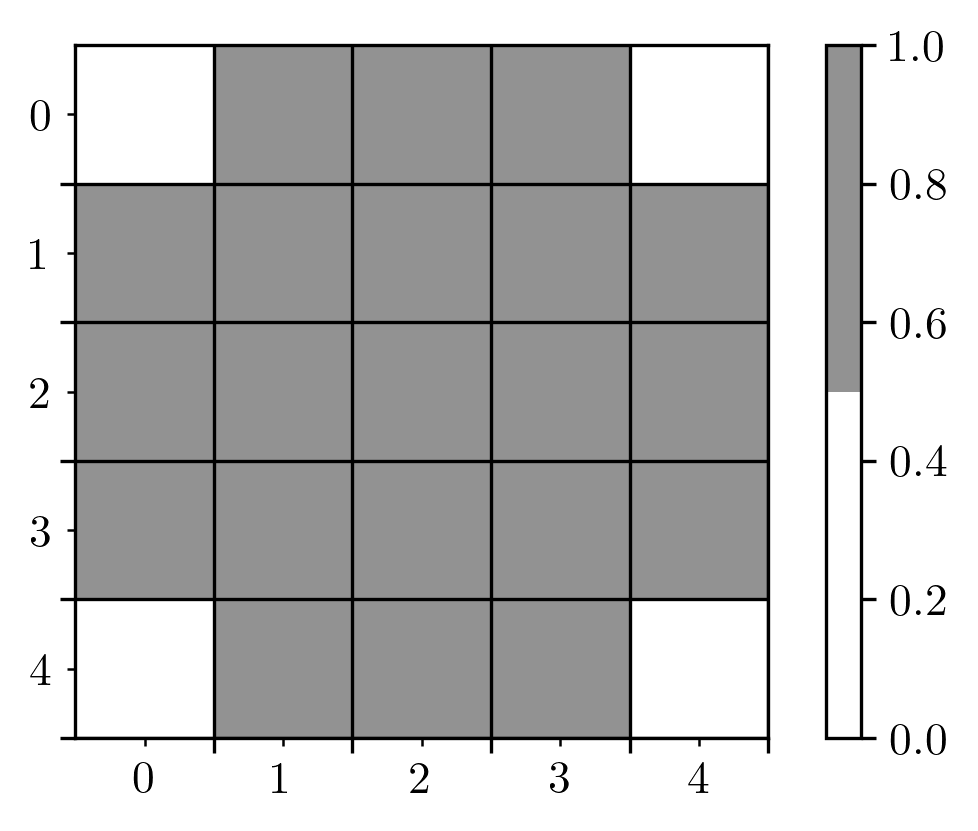

In [4]:
brush = notched_square_brush(5, 1)
show_mask(brush)

## Initial Device

In [5]:
#| exports

# Initialize the parametrization rho and the design region
epsr, bg_epsr, design_region, input_slice, output_slice = init_domain(
    Nx, Ny, Npml, space=space, wg_width=wg_width, space_slice=space_slice
)

epsr_total = mask_combine_epsr(epsr, bg_epsr, design_region)

# Setup source
source = insert_mode(omega, dl, input_slice.x, input_slice.y, epsr_total, m=1)

# Setup probe
probe = insert_mode(omega, dl, output_slice.x, output_slice.y, epsr_total, m=2)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


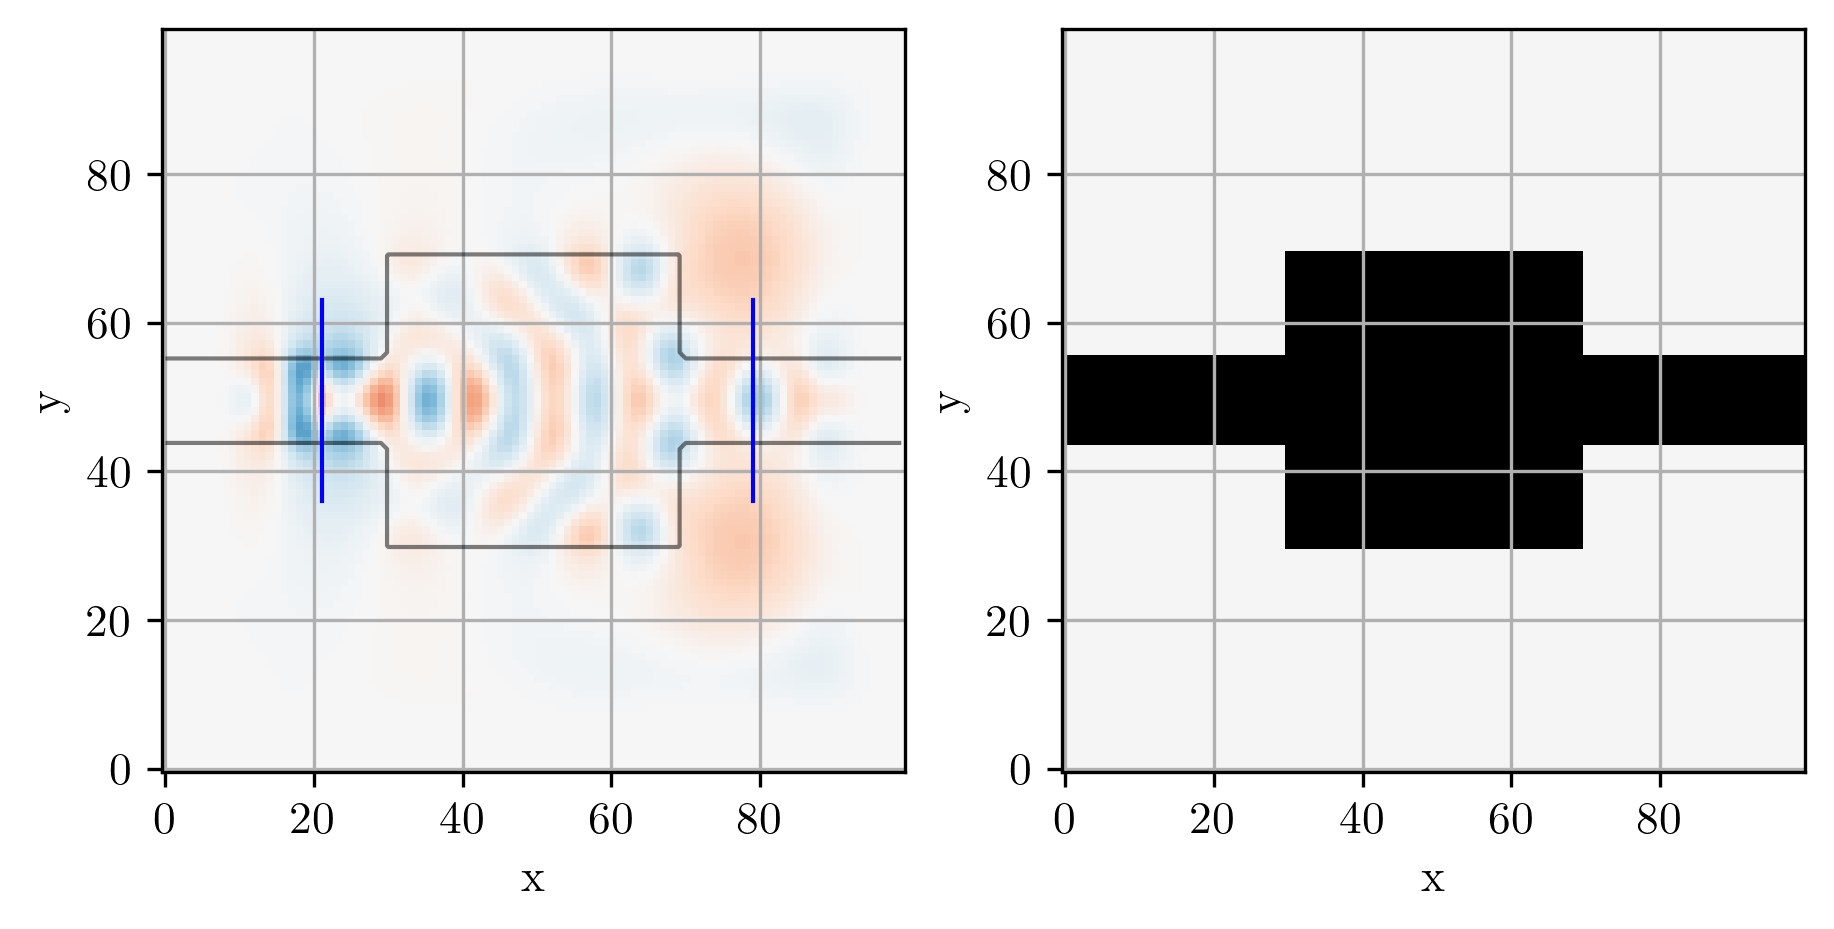

In [6]:
# Simulate initial device
simulation, ax = viz_sim(epsr_total, source, slices=[input_slice, output_slice])

# get normalization factor (field overlap before optimizing)
_, _, Ez = simulation.solve(source)
E0 = mode_overlap(Ez, probe)

In [7]:
def get_design_region(epsr, design_region=design_region):
    I = np.where(design_region.sum(0) > 1e-5)[0]
    J = np.where(design_region.sum(1) > 1e-5)[0]
    return epsr[I,:][:,J]

In [8]:
def set_design_region(epsr, value, design_region=design_region):
    return np.where(design_region > 1e-5, value, epsr)

## Latent Weights

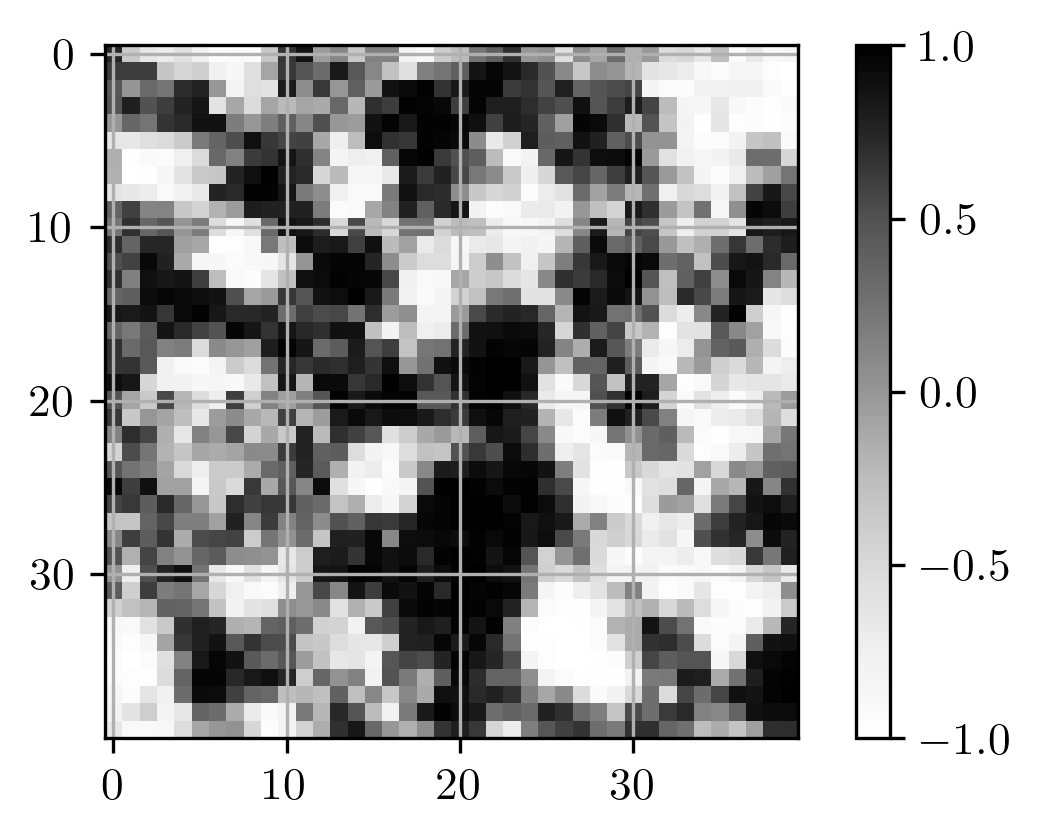

In [9]:
#latent = get_design_region(new_latent_design((Nx, Ny), r=0))
latent = new_latent_design((Nx, Ny), r=0)
latent_t = transform(latent, brush)
plt.imshow(get_design_region(latent_t), cmap="Greys", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

## Forward Pass

0: valid
1: valid
2: valid
3: valid
4: free: 0; 2
5: valid
6: free: 1; 0
7: valid
8: valid
9: valid
10: resolving
11: free: 5; 0
12: valid
13: valid
14: resolving
15: valid
16: free: 0; 2
17: valid
18: valid
19: valid
20: valid
21: valid
22: valid
23: valid
24: free: 4; 0
25: valid
26: resolving
27: resolving
28: free: 1; 0
29: valid
30: valid
31: valid
32: valid
33: valid
34: valid
35: resolving
36: resolving
37: free: 0; 16
38: valid
39: resolving
40: free: 0; 2
41: valid
42: valid
43: resolving
44: valid
45: valid
46: free: 1; 0
47: valid
48: resolving
49: resolving
50: free: 4; 0
51: valid
52: valid
53: valid
54: resolving
55: free: 0; 6
56: valid
57: valid
58: valid
59: free: 0; 7
60: resolving
61: free: 0; 15
62: valid
63: valid
64: valid
65: free: 0; 4
66: valid
67: valid
68: valid
69: valid
70: resolving
71: valid
72: resolving
73: free: 0; 4
74: resolving
75: free: 0; 26
76: valid
77: valid
78: free: 6; 0
79: valid
80: resolving
81: resolving
82: free: 0; 29
83: resolving
84: 

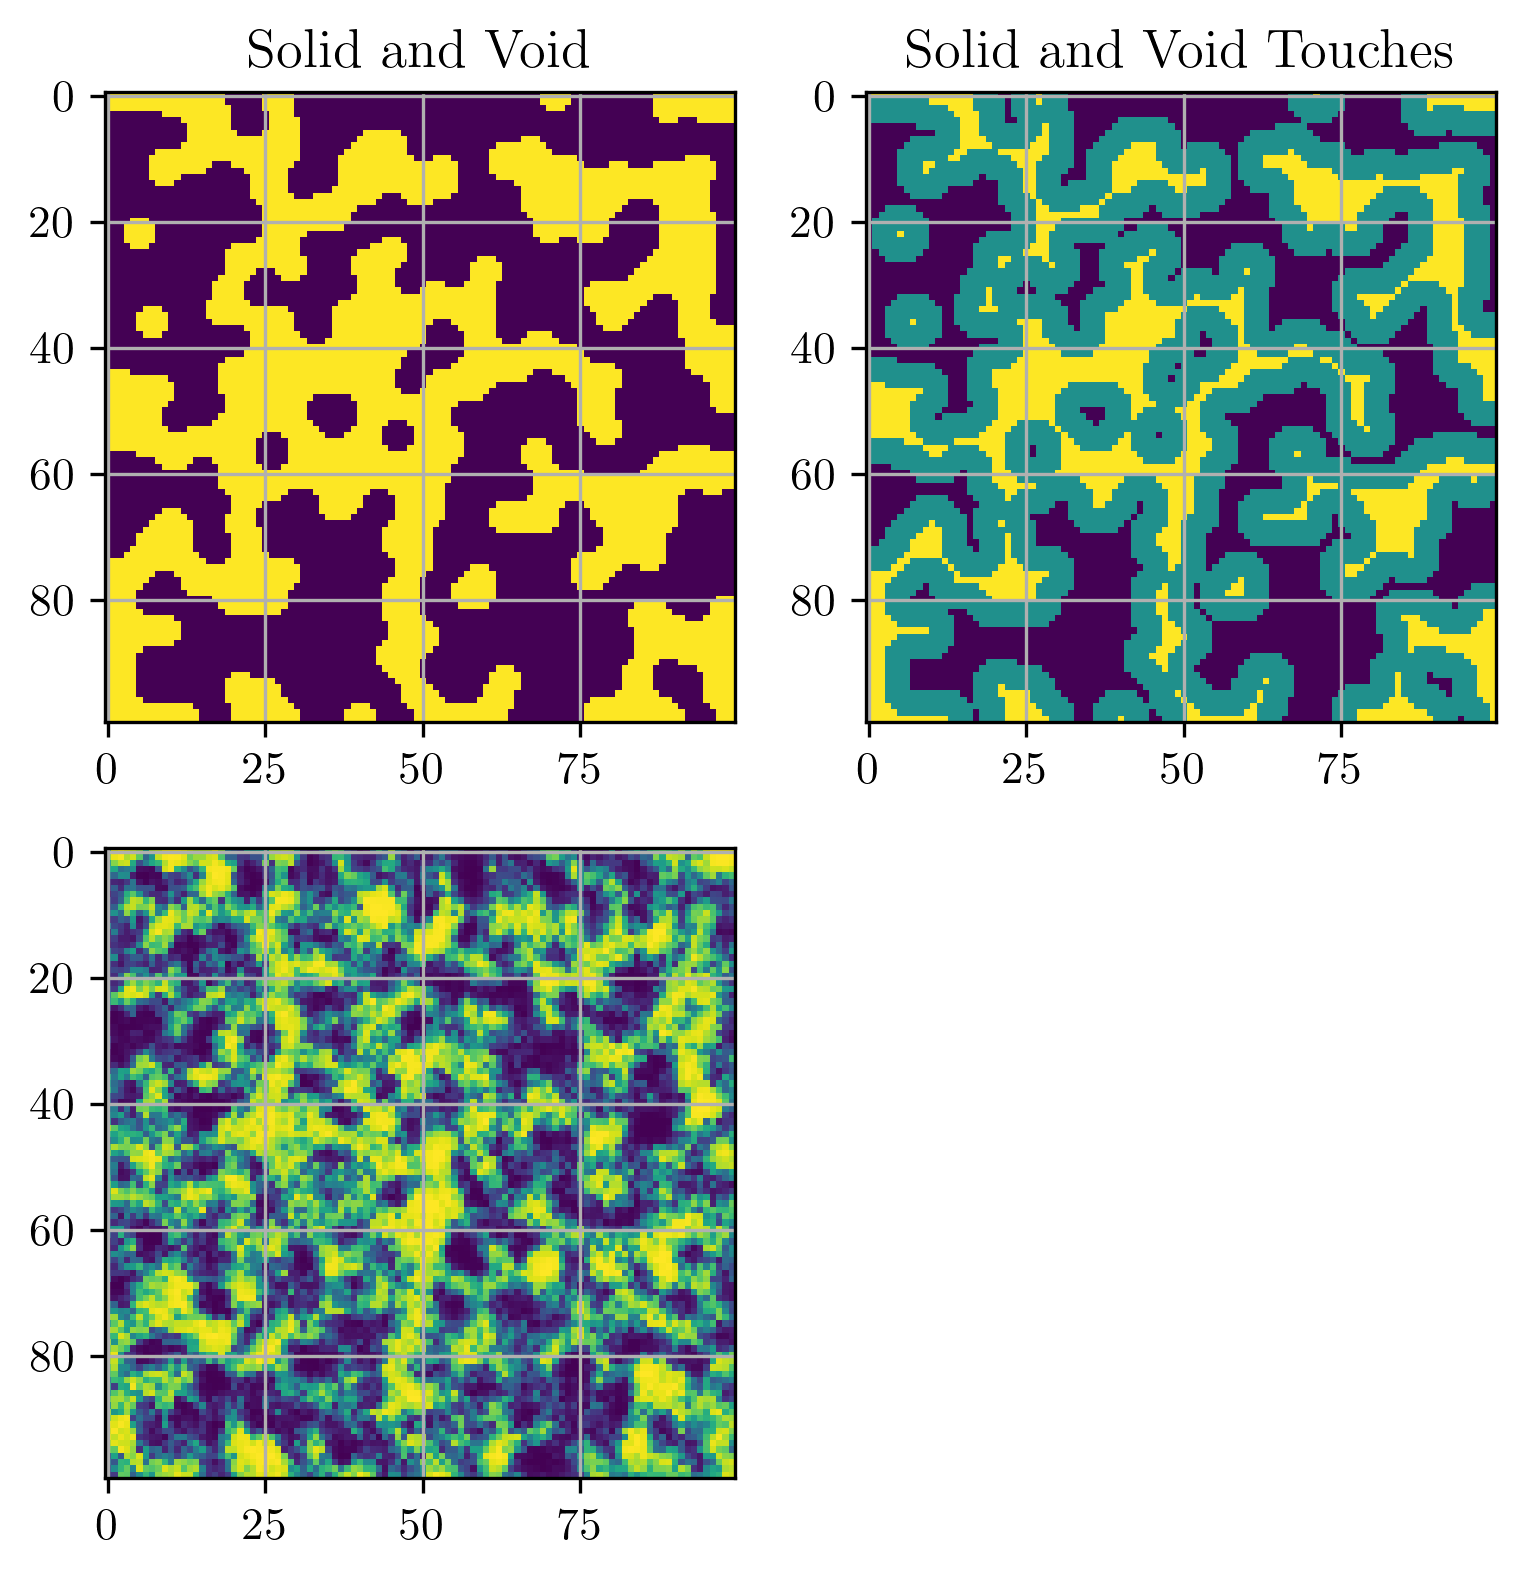

In [10]:
design = generate_feasible_design(latent_t, brush, verbose=True)

In [11]:
mask = generate_feasible_design_mask(latent_t, brush)

CPU times: user 898 ms, sys: 31.7 ms, total: 929 ms
Wall time: 930 ms


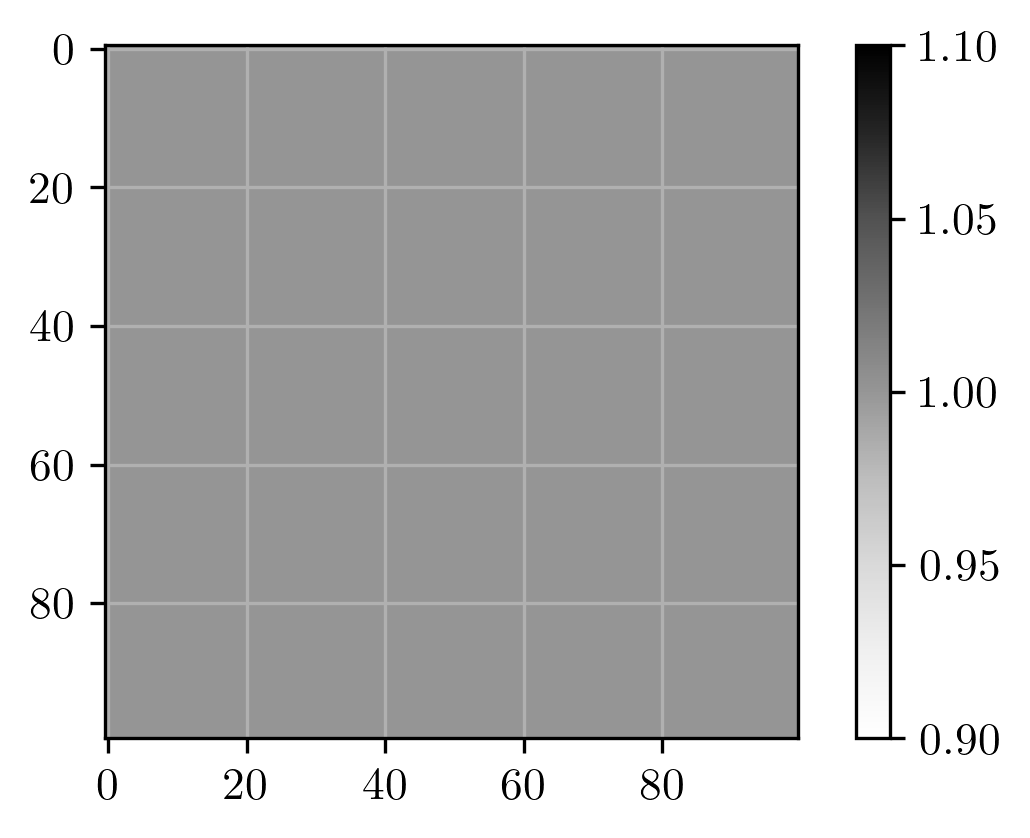

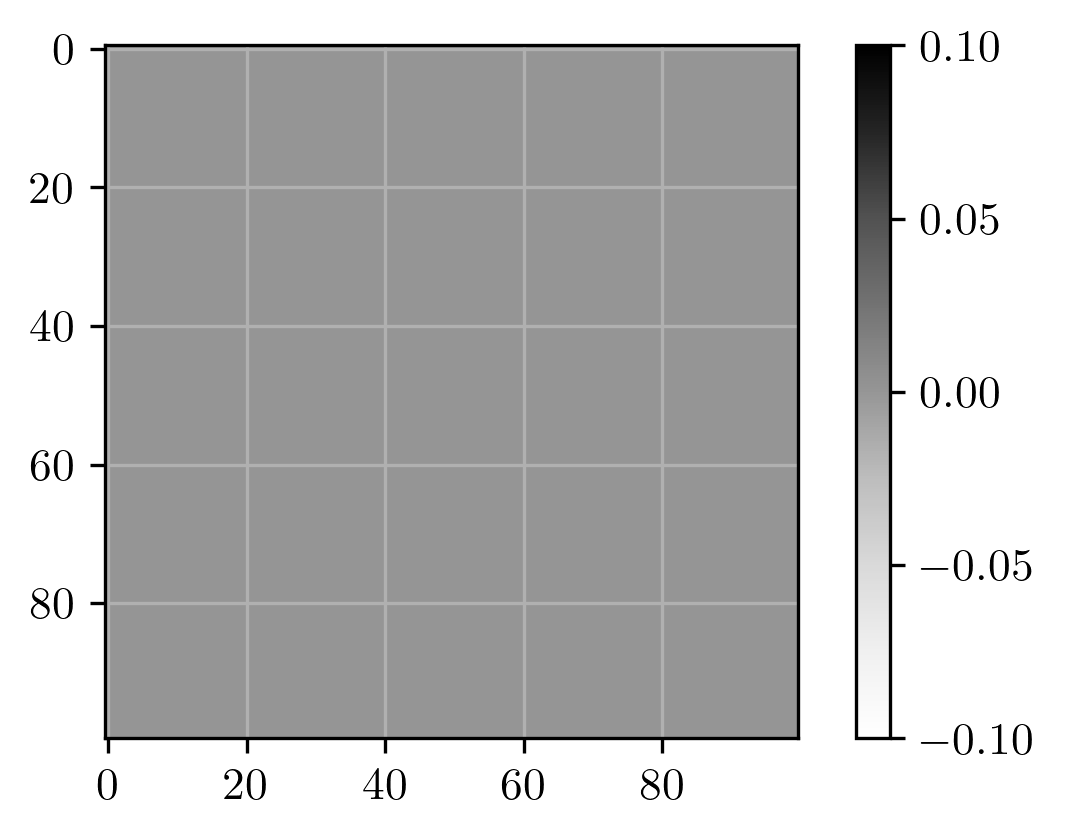

In [12]:
%time mask = generate_feasible_design_mask(latent_t, brush, )
full_mask = np.zeros_like(epsr, dtype=bool)
#full_mask = set_design_region(full_mask, mask)

plt.imshow(mask, cmap="Greys")
plt.colorbar()
plt.show()

plt.imshow(full_mask, cmap="Greys")
plt.colorbar()
plt.show()

In [13]:
#| exports
def forward(latent_weights, brush):
    latent_t = transform(latent_weights, brush)
    design_mask = generate_feasible_design_mask(latent_t, brush)
    epsr = np.where(design_mask, 12.0, 1.0)

In [14]:
#| exports
def loss_fn(epsr):
    epsr = epsr.reshape((Nx, Ny))
    simulation.eps_r = mask_combine_epsr(epsr, bg_epsr, design_region)
    _, _, Ez = simulation.solve(source)
    return -mode_overlap(Ez, probe) / E0

In [15]:
#| exports
grad_fn = jacobian(loss_fn, mode='reverse')

### Optimization

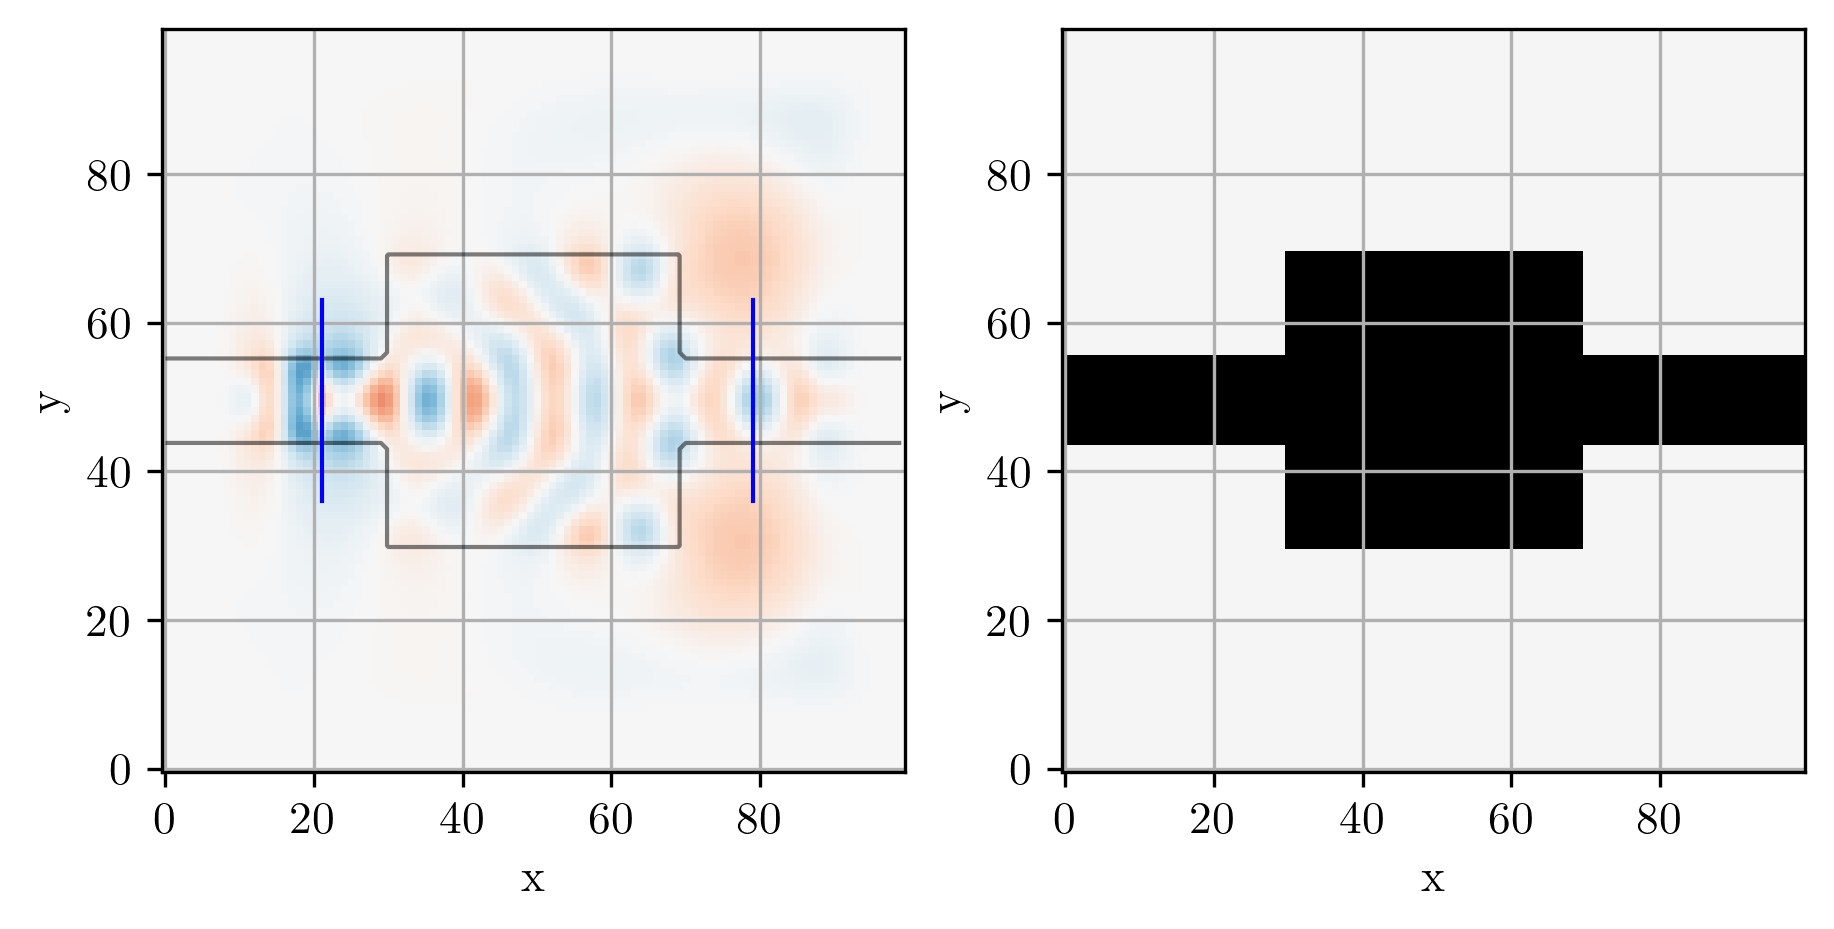

In [16]:
# Simulate initial device
simulation, ax = viz_sim(epsr_total, source, slices=[input_slice, output_slice])

In [17]:
init_fn, update_fn, params_fn = adam(step_size)
state = init_fn(epsr.reshape(1, -1))

this is the optimization step:

In [18]:
#| export
def step_fn(step, state):
    latent = np.asarray(params_fn(state), dtype=float) # we need autograd arrays here...
    loss = loss_fn(latent)
    grads = grad_fn(latent)
    optim_state = update_fn(step, grads, state)
    return loss, optim_state

we can now loop over the optimization:

In [19]:
range_ = trange(500)
for step in range_:
    loss, state = step_fn(step, state)
    range_.set_postfix(loss=float(loss))

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
epsr_optimum = params_fn(state)
epsr_optimum = epsr_optimum.reshape((Nx, Ny))

In [ ]:
# Simulate and show the optimal device
epsr_optimum_total = mask_combine_epsr(epsr_optimum, bg_epsr, design_region)
simulation, ax = viz_sim(epsr_optimum_total, source, slices=[input_slice, output_slice])

At the end of the optimization we can see our final device. From the field pattern, we can easily observe that the device is doing what we intend: the *even* mode enters from the left and exits as the *odd* mode on the right.

However, an additional observation is that our device's permittivity changes continuously. This is not ideal if we wanted to fabricated our device. We're also not constraining the minimum and maximum values of $\epsilon_r$. Thus, we need to consider alternative ways of parameterizing our device.

In [ ]:
plt.imshow(np.sqrt(epsr_optimum_total.T), cmap="plasma", vmin=1, vmax=4)
plt.ylim(*plt.ylim()[::-1])
plt.colorbar(ticks=[1,2,3,4], label="n")
plt.xlabel("x")
plt.xlabel("y")
plt.grid(True)